In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import smtplib
from os.path import basename
from email.mime.application import MIMEApplication
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.utils import COMMASPACE, formatdate

def noticeEMail(usr, psw, send_from, send_to, subject, text, files=None):
    assert isinstance(send_to, list)
    
    msg = MIMEMultipart()
    msg['From'] = send_from
    msg['To'] = COMMASPACE.join(send_to)
    msg['Date'] = formatdate(localtime=True)
    msg['Subject'] = subject

    msg.attach(MIMEText(text))

    for f in files or []:
        with open(f, "rb") as fil:
            part = MIMEApplication(
                fil.read(),
                Name=basename(f)
            )
        # After the file is closed
        part['Content-Disposition'] = 'attachment; filename="%s"' % basename(f)
        msg.attach(part)
    
    server=smtplib.SMTP('smtp.gmail.com:587')
    server.starttls()
    server.login(usr,psw)
    server.sendmail(send_from, send_to, msg.as_string())
    server.quit()

In [3]:
usr = 'vitaliy.kozin@phystech.edu'
psw = 'VitaliyKozin'
send_from = 'vitaliy.kozin@phystech.edu'
subject = 'Autoencoder progress'
send_to = ['vkozin97@gmail.com']

In [9]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

x_train = []
labels_train = []
for i in range(5):
    data_dict = unpickle('data/cifar-10-batches-py/data_batch_' + str(i+1))
    if i == 0:
        x_train = data_dict[b'data']
        labels_train = data_dict[b'labels']
    else:
        x_train = np.append(x_train, data_dict[b'data'], axis=0)
        labels_train = np.append(labels_train, data_dict[b'labels'], axis=0)
data_dict = unpickle('data/cifar-10-batches-py/test_batch')
x_test = data_dict[b'data']
labels_test = np.array(data_dict[b'labels'])

x_train = x_train.reshape((-1, 3, 32, 32))
x_test = x_test.reshape((-1, 3, 32, 32))

x_train = x_train.swapaxes(1, 3).swapaxes(1, 2)
x_test = x_test.swapaxes(1, 3).swapaxes(1, 2)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [3]:
labels_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
len(labels_names)

10

In [1]:
from __future__ import print_function
import keras
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape, Input, Concatenate, UpSampling2D
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from PIL import Image
import numpy as np
import os
from time import clock

batch_size = 32
num_classes = 10
epochs = 200
data_augmentation = False
save_dir = os.path.join(os.getcwd(), 'saved_models_cifar')
model_name = 'keras_cifar10_trained_model_with_augmentation'

Using TensorFlow backend.


In [7]:
needed_class = 7

def make_y(x, labels, needed_class):
    return np.array([x[i] if labels[i] == needed_class else np.zeros(x.shape[1:]) + 0.5 for i in range(x.shape[0])])

y_train = make_y(x_train, labels_train, needed_class)
y_test = make_y(x_test, labels_test, needed_class)

In [12]:
def get_encoder(inp):
    
    conv1 = Conv2D(64, (3, 3), padding='same', activation='relu')(inp)
    maxpool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv1)
    #dropout1 = Dropout(0.1)(maxpool1)
    
    conv2 = Conv2D(64, (3, 3), padding='same', activation='relu')(maxpool1)
    maxpool2 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv2)
    dropout2 = Dropout(0.15)(maxpool2)
    
    #conv3 = Conv2D(64, (3, 3), padding='same', activation='relu')(dropout2)
    #maxpool3 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv3)
    #dropout3 = Dropout(0.15)(maxpool3)
    
    reshape1 = Reshape((-1,))(dropout2)
    dense1 = Dense(128, activation='relu')(reshape1)
    
    return dense1


def get_decoder(encoder):
    
    dense2 = Dense(8 * 8, activation='relu')(encoder)
    reshape2 = Reshape((8, 8, -1))(dense2)
    
    #conv4 = Conv2D(64, (3, 3), padding='same', activation='relu')(dropout3)
    #upsample1 = UpSampling2D((2, 2))(conv4)
    #dropout4 = Dropout(0.15)(upsample1)
    
    conv5 = Conv2D(64, (3, 3), padding='same', activation='relu')(reshape2)
    upsample2 = UpSampling2D((2, 2))(conv5)
    #dropout5 = Dropout(0.1)(upsample2)
    
    conv6 = Conv2D(64, (3, 3), padding='same', activation='relu')(upsample2)
    upsample3 = UpSampling2D((2, 2))(conv6)
    dropout6 = Dropout(0.15)(upsample3)
    
    conv8 = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(dropout6)
    
    return conv8


def build_encoder_decoder_model(input_shape, lr, decay):

    inp = Input(shape=input_shape, dtype="float32")
    
    print(inp.get_shape().as_list())
    
    encoder = get_encoder(inp)
    decoder = get_decoder(encoder)
    
    model = Model(inp, decoder)
    opt = keras.optimizers.rmsprop(lr=lr, decay=decay)
    #opt.lr = lr
    #opt.decay = decay
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_squared_error'])
    
    return model


def build_encoder_dense_model(input_shape, num_classes, lr, decay):
    
    inp = Input(shape=input_shape, dtype="float32")
    
    encoder = get_encoder(inp)
    dense2 = Dense(num_classes, activation='softmax') (encoder)
    
    model = Model(inp, dense2)
    opt = keras.optimizers.rmsprop(lr=lr, decay=decay)
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [13]:
model = build_encoder_decoder_model(x_train.shape[1:], 0.0001, 1e-6)

print('Model summary:')
print(model.summary())

[None, 32, 32, 3]
Model summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
reshape_9 (Reshape)          (None, 4096)  

In [10]:
def gen_dataset_stratified_by_needed_class(x, y, labels, needed_class, shuffle=True):
    indexes = (labels == needed_class)
    res_x = x[indexes]
    res_y = y[indexes]
    indexes = np.arange(len(labels))[labels != needed_class]
    indexes = np.random.choice(indexes, res_x.shape[0])
    res_x = np.concatenate((res_x, x[indexes]))
    res_y = np.concatenate((res_y, y[indexes]))
    indexes = np.arange(res_x.shape[0])
    if shuffle:
        np.random.shuffle(indexes)
    return res_x[indexes], res_y[indexes]

In [11]:
def fit_model(model, x_train, y_train, x_test, y_test, labels_train, labels_test, needed_class, epochs, data_augmentation=True, verbose=False):
    histories = []
    validation_data = []
    
    if not data_augmentation:
        for epoch in range(epochs):
            if verbose:
                print('epoch ' + str(epoch + 1) + '/' + str(epochs), end=' ')
            t = clock()
            x, y =  gen_dataset_stratified_by_needed_class(x_train, y_train, labels_train, needed_class, shuffle=False)
            histories.append(
                model.fit(x, y,
                          batch_size=batch_size,
                          epochs=1,
                          verbose=0,
                          #validation_data=(x_test, y_test),
                          shuffle=True,
                          #sample_weight = (labels_train == needed_class) * 8 + 1,
                          #initial_epoch = epoch
                         ).history
            )
            x, y = gen_dataset_stratified_by_needed_class(x_test, y_test, labels_test, needed_class, shuffle=False)
            validation_data.append(
                model.evaluate(x, y, verbose=0)
            )
            if verbose:
                print('loss - ' + str(histories[-1].history['loss']) + ', validation loss - ' + str(validation_data[-1]), end = '; time: ')
                print(str(clock() - t) + ' sec')

    else:
        if verbose:
            print('Using real-time data augmentation.')
        # This will do preprocessing and realtime data augmentation:
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False,
            )  # randomly flip images

        # Compute quantities required for feature-wise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(x_train)

        # Fit the model on the batches generated by datagen.flow().
        for epoch in range(epochs):
            #K.set_value(model.optimizer.lr, K.get_value(model.optimizer.lr) * 1. / (1. + decay * epoch))
            #lrs.append(K.get_value(model.optimizer.lr))

            if verbose:
                print('epoch ' + str(epoch + 1) + '/' + str(epochs), end=': ')
            t = clock()
            x, y =  gen_dataset_stratified_by_needed_class(x_train, y_train, labels_train, needed_class)
            histories.append(
                model.fit_generator(datagen.flow(x, y,
                                                 batch_size=batch_size),
                                    steps_per_epoch=int(np.ceil(x.shape[0] / float(batch_size))),
                                    epochs=1,
                                    verbose=0,
                                    #validation_data=(x_test, y_test),
                                    #sample_weight = (labels_train == needed_class) * 8 + 1,
                                    initial_epoch=0,
                                    workers=4,
                                    max_queue_size=5
                                    ).history
            )
            x, y = gen_dataset_stratified_by_needed_class(x_test, y_test, labels_test, needed_class, shuffle=False)
            validation_data.append(
                model.evaluate(x, y, verbose=0)
            )
            if verbose:
                print('loss - ' + str(histories[-1].history['loss']) + ', validation loss - ' + str(validation_data[-1]), end = '; time: ')
                print(str(int(clock() - t)) + ' sec')
                
    return histories, validation_data

In [12]:
import pickle

In [13]:
histories = []
validation_data = []

verbose = False
use_email = True

lr = 0.0001
decay = 1e-6

data_augmentation = False

for needed_class in range(num_classes):
    t = clock()
    y_train = make_y(x_train, labels_train, needed_class)
    y_test = make_y(x_test, labels_test, needed_class)
    
    model = build_encoder_decoder_model(x_train.shape[1:], lr, decay)
    
    s = 'Training class #' + str(needed_class) + '\n'
    print(s, end='')
    if use_email:
        noticeEMail(usr, psw, send_from, send_to, subject, s)
    
    hist, valid = fit_model(model, x_train, y_train, x_test, y_test, labels_train, labels_test, needed_class, epochs, verbose=verbose, data_augmentation=data_augmentation)
    histories.append(hist)
    validation_data.append(valid)
    
    try:
        s = 'Trained ' + str(clock() - t) + ' sec'
        if not verbose:
            print(s)
        if use_email:
            noticeEMail(usr, psw, send_from, send_to, subject, s)

        model_path = os.path.join(save_dir, model_name + '_' + str(needed_class) + '.h5')
        model.save(model_path)

        if not verbose:
            print('Saved trained model at %s ' % model_path)

        print('_' * 20)
        print()

        with open(save_dir + '/histories', 'wb') as f:
            pickle.dump(histories, f)
        with open(save_dir + '/validation_data', 'wb') as f:
            pickle.dump(validation_data, f)
    except Exception:
        s = 'something went wrong on class ' + str(needed_class)
        print(s)
        if use_email:
            noticeEMail(usr, psw, send_from, send_to, subject, s)

Training class #0
Trained 1436.4942509999998 sec
Saved trained model at /home/dl3/v.kozin/selective_autoencoder/saved_models_cifar/keras_cifar10_trained_model_with_augmentation_0.h5 
____________________

Training class #1
Trained 1436.1023449999998 sec
Saved trained model at /home/dl3/v.kozin/selective_autoencoder/saved_models_cifar/keras_cifar10_trained_model_with_augmentation_1.h5 
____________________

Training class #2
Trained 1443.2842640000003 sec
Saved trained model at /home/dl3/v.kozin/selective_autoencoder/saved_models_cifar/keras_cifar10_trained_model_with_augmentation_2.h5 
____________________

Training class #3
Trained 1444.5866779999997 sec
Saved trained model at /home/dl3/v.kozin/selective_autoencoder/saved_models_cifar/keras_cifar10_trained_model_with_augmentation_3.h5 
____________________

Training class #4
Trained 1449.3942640000005 sec
Saved trained model at /home/dl3/v.kozin/selective_autoencoder/saved_models_cifar/keras_cifar10_trained_model_with_augmentation_4.h

In [14]:
with open(save_dir + '/histories', 'rb') as f:
    histories = pickle.load(f)
with open(save_dir + '/validation_data', 'rb') as f:
    validation_data = pickle.load(f)

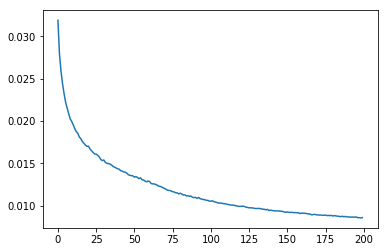

In [20]:
needed_class = 1
plt.plot(range(len(histories[needed_class])), [x['loss'] for x in histories[needed_class]])

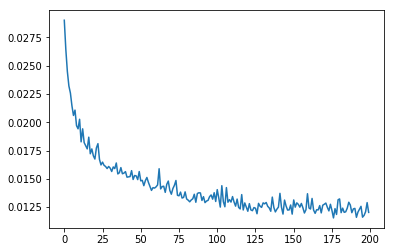

In [21]:
needed_class = 1
plt.plot(range(len(validation_data[needed_class])), [x[0] for x in validation_data[needed_class]])

In [22]:
def mirror(arr, gamma):
    res = np.zeros(len(arr))
    res[0] = arr[0]
    for i in range(1, len(arr)):
        res[i] = (1 - gamma) * arr[i] + gamma * res[i - 1]
    return res

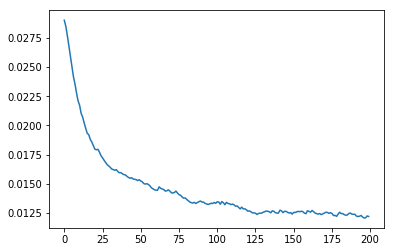

In [24]:
needed_class = 1
arr = mirror([x[0] for x in validation_data[needed_class]], 0.8)
plt.plot(range(len(arr)), arr)

In [25]:
if use_email:
    for needed_class in range(num_classes):
        noticeEMail(usr, psw, send_from, send_to, subject, 'net for class ' + str(needed_class),
                    [os.path.join(save_dir, model_name + '_' + str(needed_class) + '.h5')])
    
    #noticeEMail(usr, psw, send_from, send_to, subject, 'net for class ' + str(needed_class),
    #            [save_dir + '/' + model_name + '_' + str(i) + '.h5' for i in range(10)])

In [26]:
if use_email:
    noticeEMail(usr, psw, send_from, send_to, subject, 'History of training',
                [os.path.join(save_dir, 'histories'),
                 os.path.join(save_dir, 'validation_data')])

In [27]:
def my_norm(img, projection):
    img = np.array(img, dtype='float32')
    projection = np.array(projection, dtype='float32')
    return np.sqrt(((projection - projection.mean())**2).sum()) / np.sqrt(((img - img.mean())**2).sum())

def old_accuracy(model, x, labels, needed_class, treshold=0.5):
    pred = model.predict(x)
    pred = np.array([my_norm(x[i], pred[i]) for i in range(x.shape[0])])
    pred = np.clip(pred, 0, 1)
    labels = np.array(labels==needed_class, dtype=pred.dtype)
    return ((pred > treshold) == labels).mean()

def accuracy(x, labels):
    norms = np.zeros((x.shape[0], num_classes))
    for i in range(num_classes):
        model_path = os.path.join(save_dir, model_name + '_' + str(i) + '.h5')
        model = keras.models.load_model(model_path)
        pred = model.predict(x)
        norms[:, i] = [my_norm(x[i], pred[i]) for i in range(x.shape[0])]
    preds = norms.argmax(axis=1)
    return (preds == labels).mean()

In [28]:
%%time
acc1 = accuracy(x_train, labels_train)
print(acc1)

0.98726
CPU times: user 2min 34s, sys: 8.21 s, total: 2min 42s
Wall time: 2min 35s


In [29]:
%%time
acc2 = accuracy(x_test, labels_test)
print(acc2)

0.7449
CPU times: user 1min 4s, sys: 1.23 s, total: 1min 5s
Wall time: 1min 3s


In [31]:
if use_email:
    noticeEMail(usr, psw, send_from, send_to, subject, 'Train and test accuracies of "'
                + model_name + '" are\n' + str(acc1) + '\n' + str(acc2))

In [6]:
lr = 1e-4
decay = 1e-6

model2 = build_encoder_dense_model(x_train.shape[1:], num_classes, lr, decay)
encoder_dense_name = 'encoder_dense_model'

print(model2.summary())

NameError: name 'build_encoder_dense_model' is not defined

In [32]:
%%time
one_hot_labels_train = keras.utils.to_categorical(labels_train, num_classes)
one_hot_labels_test = keras.utils.to_categorical(labels_test, num_classes)

history = model2.fit(x_train, one_hot_labels_train, validation_data=(x_test, one_hot_labels_test),
                     batch_size=batch_size, epochs=epochs, verbose=False).history

CPU times: user 53min 19s, sys: 3min 52s, total: 57min 11s
Wall time: 50min 48s


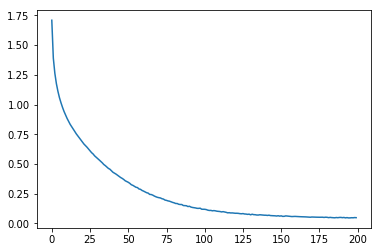

In [138]:
plt.plot(range(len(history['loss'])), history['loss'])

In [132]:
history.keys()

dict_keys(['loss', 'val_acc', 'acc', 'val_loss'])

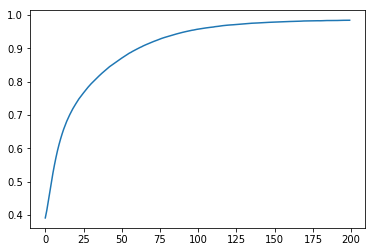

In [137]:
plt.plot(range(len(history['acc'])), mirror(history['acc'], 0.8))

In [33]:
model2.save(save_dir + '/' + encoder_dense_name + '.h5')

with open(save_dir + '/' + encoder_dense_name + '_history', 'wb') as f:
    pickle.dump(history, f)

In [15]:
import pickle
encoder_dense_name = 'encoder_dense_model'
with open(save_dir + '/' + encoder_dense_name + '_history', 'rb') as f:
    history = pickle.load(f)

EOFError: Ran out of input

In [34]:
if use_email:
    noticeEMail(usr, psw, send_from, send_to, subject, 'Files for encoder_dense_model',
                [save_dir + '/' + encoder_dense_name + '.h5', save_dir + '/' + encoder_dense_name + '_history'])

In [3]:
%%time
needed_class = 7
model = keras.models.load_model(save_dir + '/' + model_name + '_' + str(needed_class) + '.h5')

CPU times: user 812 ms, sys: 128 ms, total: 940 ms
Wall time: 918 ms


In [36]:
number = -1

automobile
6415


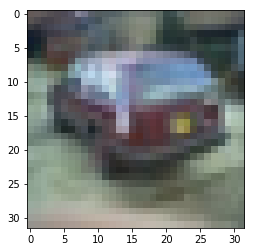

In [115]:
test_mode = True
isneeded = False
#number += 1
if test_mode:
    index = np.random.choice([i for i in range(labels_test.shape[0]) if (labels_test[i] == needed_class) == isneeded])
    print(labels_names[labels_test[index]])
else:
    index = np.random.choice([i for i in range(labels_train.shape[0]) if (labels_train[i] == needed_class) == isneeded])
    print(labels_names[labels_train[index]])
print(index)
if test_mode:
    img = Image.fromarray(np.array(x_test[index].reshape((32, 32, -1)) * 255, dtype='uint8'))#, interpolation='None')
    plt.imshow(np.array(x_test[index].reshape((32, 32, -1))), interpolation='None', cmap='gray')
else:
    img = Image.fromarray(np.array(x_train[index].reshape((32, 32, -1)) * 255, dtype='uint8'))#, interpolation='None')
    plt.imshow(np.array(x_train[index].reshape((32, 32, -1))), interpolation='None', cmap='gray')
#img.save('data/test_photos_mnist/class_' + str(needed_class) + '_true.jpg')

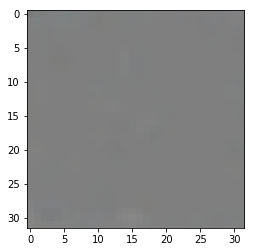

In [116]:
if test_mode:
    plt.imshow(model.predict(np.array([x_test[index]]))[0], interpolation='None')
else:
    plt.imshow(model.predict(np.array([x_train[index]]))[0], interpolation='None')

In [139]:
def make_example_picture(test_mode = False, pict_size = (420, 470), start_imgs = (30, 30), start_table = (30, 80), stripes = (5, 5)):
    img_shape = x_train[0].shape
    
    real_images = []
    output_picture = np.zeros(pict_size + (3,)) + 1
    for real_class in range(num_classes):
        if test_mode:
            real_images.append(x_test[np.random.choice([i for i in range(labels_test.shape[0]) if (labels_test[i] == real_class)])])
        else:
            real_images.append(x_train[np.random.choice([i for i in range(labels_train.shape[0]) if (labels_train[i] == real_class)])])
        output_picture[start_imgs[0] + real_class * (img_shape[0] + stripes[0]) : start_imgs[0] + real_class * (img_shape[0] + stripes[0]) + img_shape[0],
                       start_imgs[1] : start_imgs[1] + img_shape[1], :] = real_images[-1]
        
    for model_class in range(num_classes):
        model = keras.models.load_model(save_dir + '/' + model_name + '_' + str(model_class) + '.h5')
        for real_class, real_image in enumerate(real_images):
            pred = model.predict(np.array([real_image]))[0]
            output_picture[start_table[0] + real_class * (img_shape[0] + stripes[0]) : start_table[0] + real_class * (img_shape[0] + stripes[0]) + img_shape[0],
                           start_table[1] + model_class * (img_shape[1] + stripes[1]) : start_table[1] + model_class * (img_shape[1] + stripes[1]) + img_shape[1],
                           :] = pred
    return Image.fromarray(np.array(output_picture * 255, dtype='uint8'))

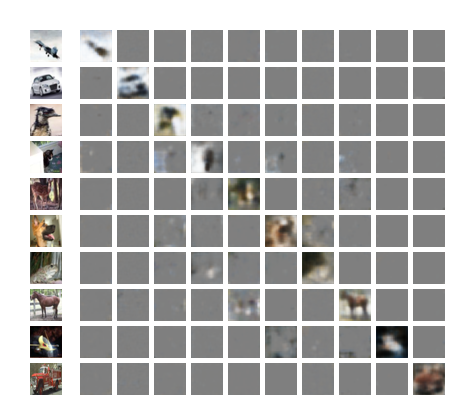

In [140]:
img = make_example_picture()
img

In [141]:
examples_dir = 'data/examples_pictures_cifar-10'
if not os.path.isdir(examples_dir):
    os.makedirs(examples_dir)

In [142]:
num_examples = 10
for test_mode in [True, False]:
    for i in range(num_examples):
        make_example_picture(test_mode = test_mode).save(examples_dir + '/example_' + ('test' if test_mode else 'train') + '_' + str(i) + '.jpg')

(1903, 635)


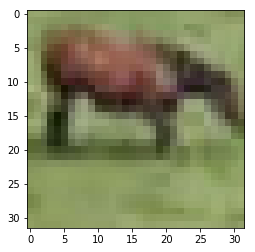

In [4]:
img = keras.preprocessing.image.load_img('data/test_photos/horse_several_small.jpg')
print(img.size)
mini_img = img.crop((580, 525, 635, 580)).resize((32, 32))
plt.imshow(np.array(mini_img) / 255, interpolation='None')

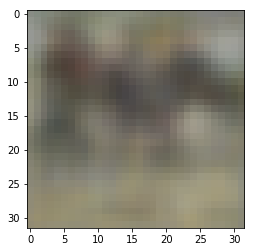

In [5]:
plt.imshow(model.predict(np.array([np.array(mini_img) / 255]))[0], interpolation='None')

In [6]:
def process_img_mean_by_windowing(img, model, window_size=(32, 32), horizontal_stripe=1, vertical_stripe=1):
    count = max(1, (img.size[0] - window_size[0] - 1) // horizontal_stripe + 2)
    horizontal_starts = np.arange(0, count * horizontal_stripe, horizontal_stripe)
    horizontal_starts -= ((count - 1) * horizontal_stripe + window_size[0] - img.size[0]) // 2
    #print(horizontal_starts)
    count = max(1, (img.size[1] - window_size[1] - 1) // vertical_stripe + 2)
    vertical_starts = np.arange(0, count* vertical_stripe, vertical_stripe)
    vertical_starts -= ((count - 1) * vertical_stripe + window_size[1] - img.size[1]) // 2
    #print(vertical_starts)
    
    if np.array(img).max() > 1:
        need_divide = True
    else:
        need_divide = False
    
    count = np.zeros((img.size[1], img.size[0], 3))
    res = np.zeros((img.size[1], img.size[0], 3))
    for start_i in vertical_starts:
        for start_j in horizontal_starts:
            #print(start_i, start_j)
            mini_img = img.crop((start_j, start_i, start_j + window_size[0], start_i + window_size[1]))
            if window_size != (32, 32):
                mini_img = mini_img.resize((32, 32))
            mini_img = np.array(mini_img)
            if need_divide:
                mini_img = mini_img / 255.
            transformed = model.predict(np.array([mini_img]))[0]
            if window_size != (32, 32):
                if need_divide:
                    transformed = np.array(transformed * 255, dtype='uint8')
                transformed = np.array(Image.fromarray(transformed).resize(window_size), dtype='float32')
                if need_divide:
                    transformed /= 255.
            #print(transformed.shape)
            #print(max(0, -start_i), window_size[1] - max(0, start_i + window_size[1] - img.size[1]))
            #print(max(0, -start_j), window_size[0] - max(0, start_j + window_size[0] - img.size[0]))
            transformed = transformed[max(0, -start_i) : window_size[1] - max(0, start_i + window_size[1] - img.size[1]),
                                      max(0, -start_j) : window_size[0] - max(0, start_j + window_size[0] - img.size[0]), :]
            #print(transformed.shape)
            count[max(0, start_i) : max(0, min(img.size[1], start_i + window_size[1])),
                  max(0, start_j) : max(0, min(img.size[0], start_j + window_size[0])), :] += 1
            res[max(0, start_i) : max(0, min(img.size[1], start_i + window_size[1])),
                max(0, start_j) : max(0, min(img.size[0], start_j + window_size[0])), :] += transformed
    count += 1e-8
    res = res / count
    return res

(1903, 635)


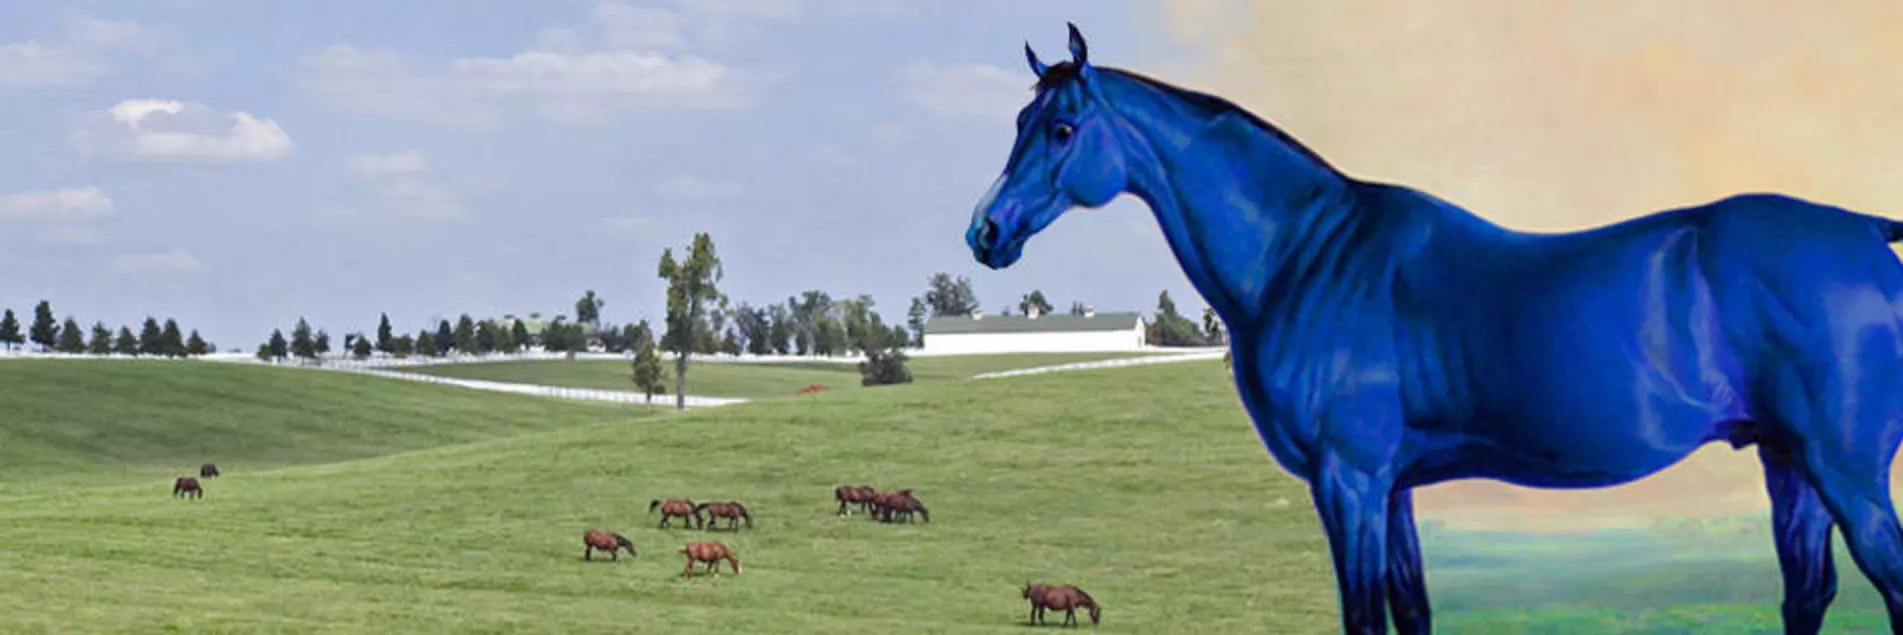

In [7]:
img = keras.preprocessing.image.load_img('data/test_photos/horse_several_small.jpg')
print(img.size)
img

100.81514100000001 sec


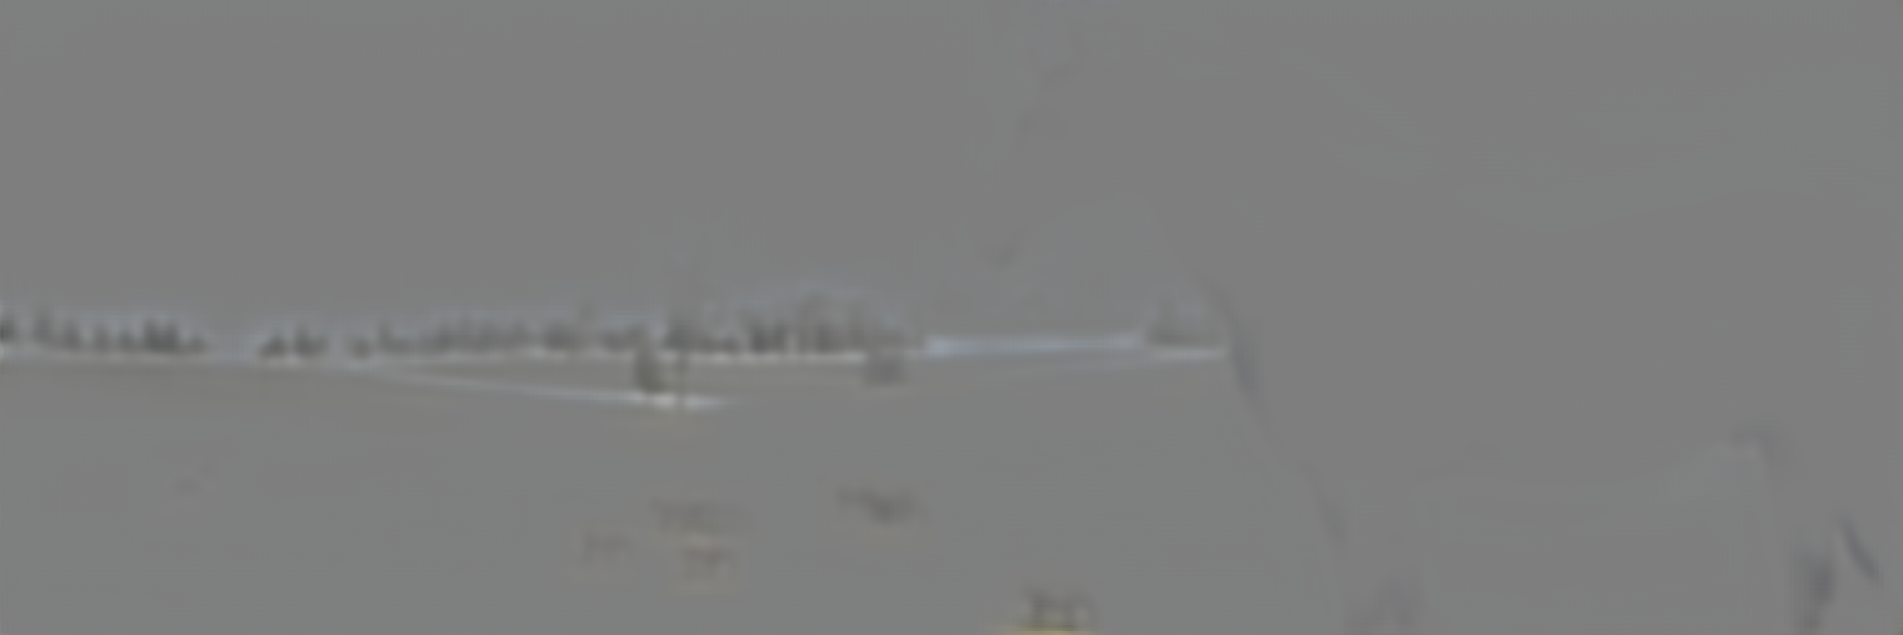

In [8]:
t = clock()
processed = process_img_mean_by_windowing(img, model, window_size=(70, 70), horizontal_stripe=5, vertical_stripe=5)
print(clock() - t, 'sec')
processed_img = Image.fromarray(np.array(processed * 255, dtype='uint8'))
processed_img

In [9]:
processed_img.save('data/test_photos/processed_horses.jpg')

In [10]:
processed_img = Image.open('data/test_photos/processed_horses.jpg')
processed = np.array(processed_img) / 255

In [11]:
print(processed.mean(), processed.std(), processed.max(), processed.min())

0.495388571004 0.0107514477147 0.654901960784 0.352941176471


In [12]:
def widen(img, coeff = None, use_sigmoid = False, return_coef = False):
    arr = np.array(img)
    m = arr.mean()
    if coeff is None:
        coeff = 2 / (arr.max() - arr.min())
        print(coeff)
    arr = (arr - m) * coeff + m
    if use_sigmoid:
        arr = 1 / (1 + np.exp(-arr))
    arr[arr > 1] = 1
    arr[arr < 0] = 0
    if return_coef:
        return arr, coef
    return arr

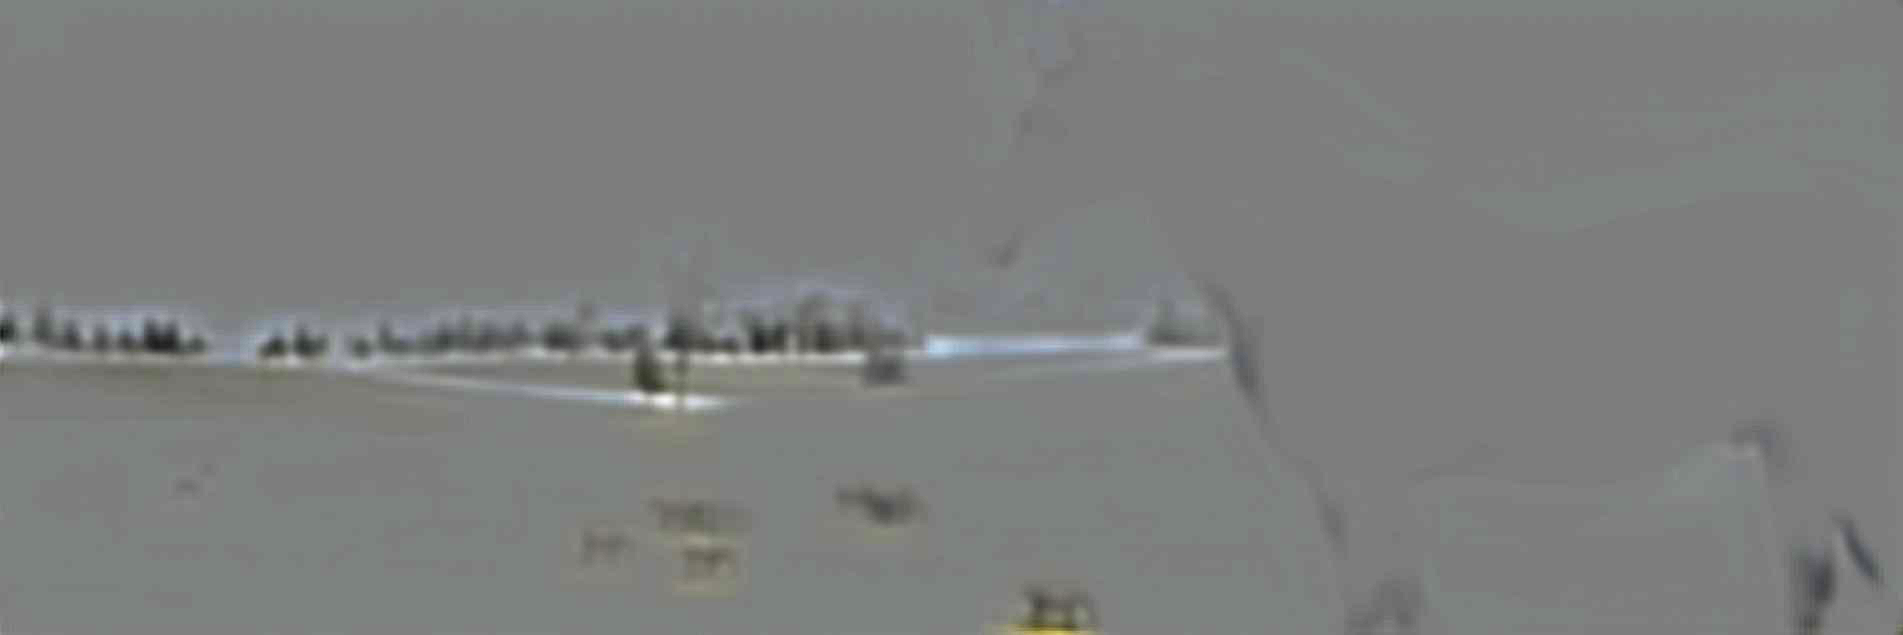

In [13]:
filtered = Image.fromarray(np.array(widen(processed, 3, False) * 255, dtype='uint8'))
filtered

In [14]:
filtered.save('data/test_photos/processed_horses_filtered_1.jpg')

6.62337662338


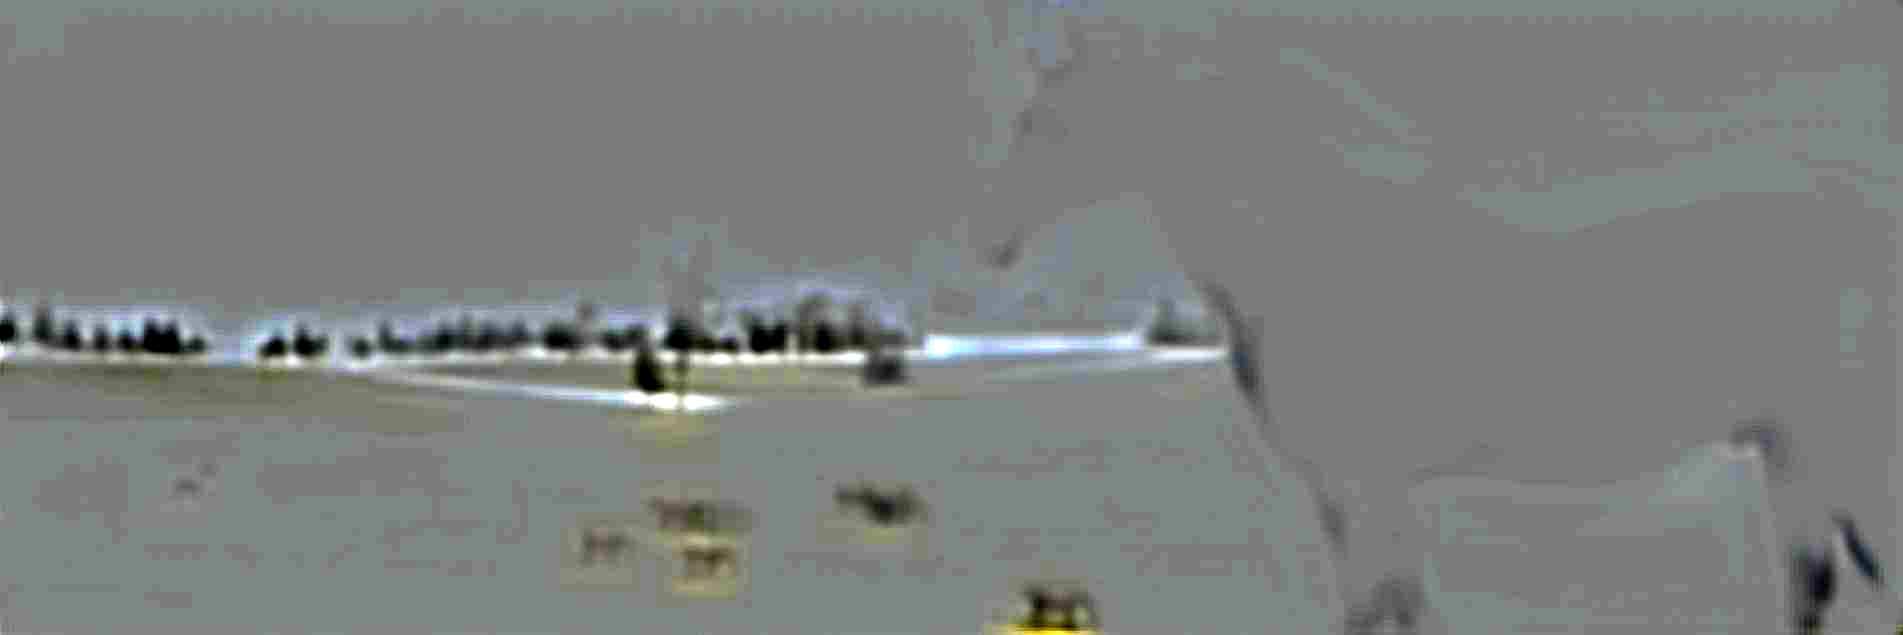

In [15]:
filtered = Image.fromarray(np.array(widen(processed) * 255, dtype='uint8'))
filtered

In [16]:
filtered.save('data/test_photos/processed_horses_filtered_2.jpg')

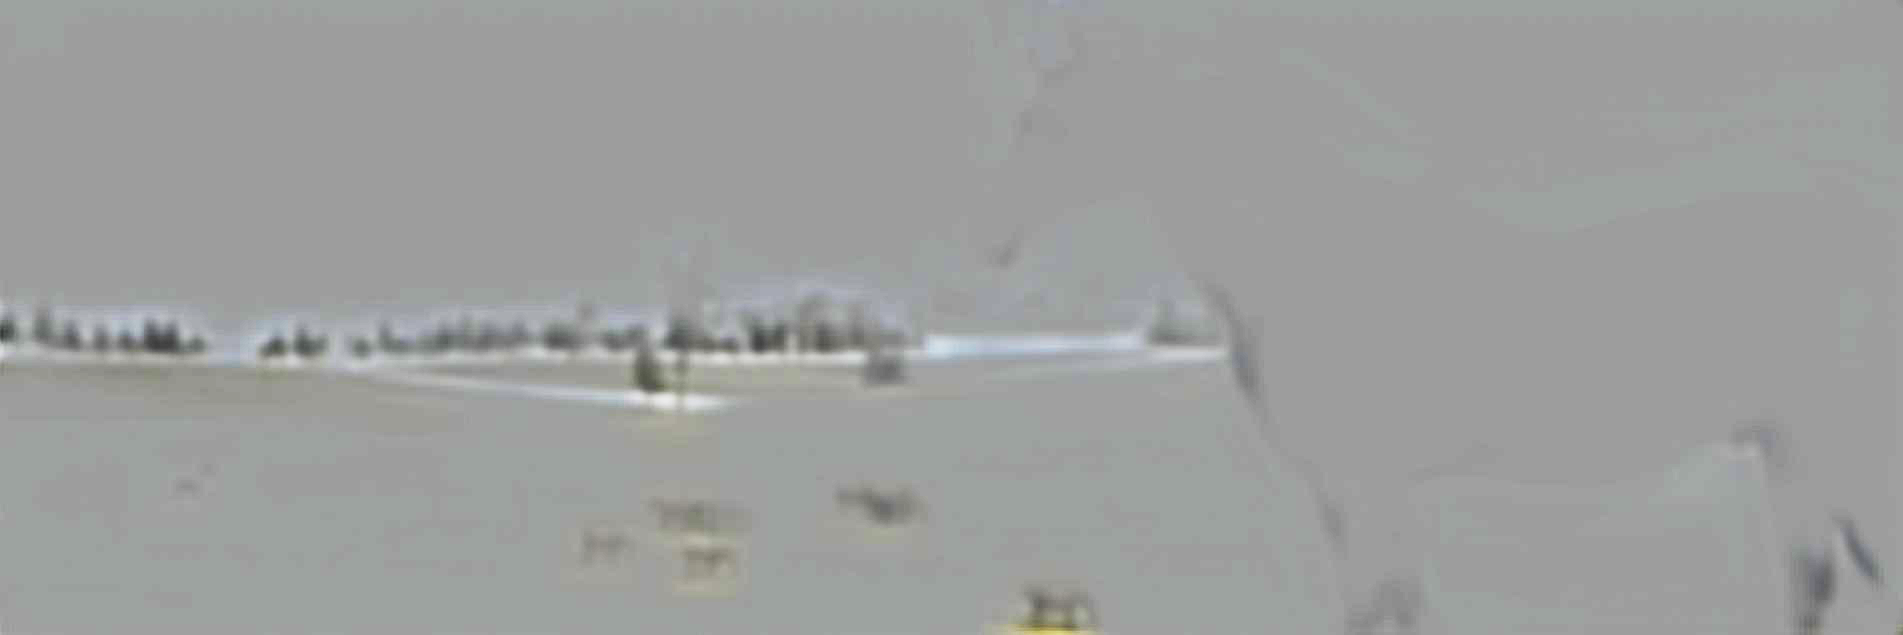

In [17]:
filtered = Image.fromarray(np.array(widen(processed, 13, True) * 255, dtype='uint8'))
filtered

In [18]:
filtered.save('data/test_photos/processed_horses_filtered_3.jpg')